# Bir Stratejinin Geriye Dönük Testi

**PyBroker** kullanarak temel bir ticaret stratejisini test etmeye hazırız! Başlamak için aşağıda listelenen gerekli sınıfları içe aktaracağız:

In [16]:
import pybroker
from pybroker import Strategy, StrategyConfig, YFinance

pybroker.enable_data_source_cache('my_strategy')

Geriye dönük testimiz için, [Veri Kaynağımız](https://www.pybroker.com/en/latest/reference/pybroker.data) olarak [Yahoo Finance](https://finance.yahoo.com) kullanacağız. html#pybroker.data.DataSource). Ayrıca, geriye dönük testlerimizi çalıştırdığımızda gerekli verileri yalnızca bir kez indirdiğimizden emin olmak için veri kaynağı önbelleğe almayı kullanacağız.

Bir sonraki adım, kullanılacak [Strategy](https://www.pybroker.com/en/latest/reference/pybroker.strategy.html#pybroker.strategy.Strategy) sınıfının yeni bir örneğini oluşturmaktır. ticaret stratejimiz üzerinde bir geriye dönük test gerçekleştirin. Bunu nasıl yapabileceğiniz aşağıda açıklanmıştır:

İlk olarak, ```Strategy```yi yapılandırmak için bir [StrategyConfig](https://www.pybroker.com/en/latest/reference/pybroker.config.html#pybroker.config.StrategyConfig) nesnesi oluşturabilirsiniz. Bu durumda, ilk nakdi ``500.000``` olarak ayarlıyoruz:

In [17]:
config = StrategyConfig(initial_cash=500_000)

Ardından, aşağıdaki bağımsız değişkenleri ileterek ```Strateji``` sınıfının yeni bir örneğini oluşturabilirsiniz:

- Bir veri kaynağı: Bu durumda veri kaynağı olarak Yahoo Finance'i kullanıyoruz.
- Başlangıç ​​tarihi: Bu, geriye dönük testin başlangıç ​​tarihidir.
- Bitiş tarihi: Bu, geriye dönük testin bitiş tarihidir.
- Daha önce oluşturulan yapılandırma nesnesi.

In [18]:
strategy = Strategy(YFinance(), '3/1/2017', '3/1/2022', config)

"Strategy" örneği artık, belirtilen yapılandırma seçeneklerini kullanarak arka testi çalıştırmadan önce 1 Mart 2017 ile 1 Mart 2022 arasındaki döneme ait verileri Yahoo Finance'den indirmeye hazır. Diğer yapılandırma seçeneklerini değiştirmeniz gerekiyorsa [StrategyConfig referans belgelerine](https://www.pybroker.com/en/latest/reference/pybroker.config.html#pybroker.config.StrategyConfig) başvurabilirsiniz.

## Strateji Kurallarını Tanımlama

Bu bölümde, **PyBroker**'da temel bir ticaret stratejisini aşağıdaki kurallarla nasıl uygulayacağınızı öğreneceksiniz:

1. Son kapanış fiyatı önceki çubuğun en düşük seviyesinden düşükse ve o hisse senedinde açık uzun pozisyon yoksa hisse senedi satın alın.
2. Alış emrinin limit fiyatını son kapanış fiyatından 0,01 daha düşük olarak ayarlayın.
3. Piyasa fiyatından tasfiye etmeden önce pozisyonu 3 gün tutun.
4. Her birine portföyün %25'ine kadar pay ayırarak, AAPL ve MSFT kurallarında işlem yapın.

Bunu başarmak için, **PyBroker**'ın her veri çubuğunda AAPL ve MSFT için ayrı ayrı çağıracağı bir ```buy_low``` işlevi tanımlayacaksınız. Her çubuk tek bir günlük veriye karşılık gelir:

In [19]:
def buy_low(ctx):
    # Hisseler zaten satın alınmışsa ve şu anda tutuluyorsa geri dönün.
    if ctx.long_pos():
        return
    # Son kapanış fiyatının bir önceki günün düşük fiyatından düşük olması durumunda,
    # daha sonra bir satın alma siparişi verin.
    if ctx.bars >= 2 and ctx.close[-1] < ctx.low[-2]:
        # Portföyün %25'ine eşit sayıda hisse satın alın.
        ctx.buy_shares = ctx.calc_target_shares(0.25)
        # Emrin limit fiyatını belirleyin.
        ctx.buy_limit_price = ctx.close[-1] - 0.01
        # Tasfiye etmeden önce pozisyonu 3 bar tutun (bu durumda 3 gün).
        ctx.hold_bars = 3

In [20]:
strategy.add_execution(buy_low, ['PGSUS.IS', 'EREGL.IS'])

## İkinci Bir Yürütme Ekleme

Aynı ```Strateji``` örneğinde farklı işaretler için farklı işlem kuralları kümeleri kullanabilirsiniz. Başka bir deyişle, tek bir hisse senedi grubu için yalnızca bir dizi işlem kuralı kullanmakla sınırlı değilsiniz.

Bunu göstermek için, kısa stratejiye yönelik yeni bir kurallar dizisi, önceki kural kümesine benzer şekilde ```short_high``` adı verilen bir işlevde sağlanmıştır:

In [21]:
def short_high(ctx):
    # Hisse senetleri zaten kısa devre yapmışsa geri dönün.
    if ctx.short_pos():
        return
    # Son kapanış fiyatının bir önceki günün en yüksek fiyatından fazla olması durumunda,
    # daha sonra satış emri verin.
    if ctx.bars >= 2 and ctx.close[-1] > ctx.high[-2]:
        # Kısa 100 paylaşım.
        ctx.sell_shares = 100
        # 2 bardan sonra (bu durumda 2 gün) paylaşımları kapatın.
        ctx.hold_bars = 2

`` Short_high``  deki kurallar ```tsla``` 

In [24]:
strategy.add_execution(short_high, ['DOAS.IS'])

(Not: [ExecContext#foreign](https://www.pybroker.com/en/latest/reference/pybroker.context.html#pybroker.context.ExecContext.foreign) numaralı telefonu arayarak başka bir sembole ait çubuk verilerini de alabileceğinizi unutmayın. )

## Bir Arka Test Çalıştırma

Bir geriye dönük test çalıştırmak için ```Strateji```de [backtest](https://www.pybroker.com/en/latest/reference/pybroker.strategy.html#pybroker.strategy.Strategy.backtest) yöntemini çağırın ' örneğin. İşte bir örnek:

In [25]:
result = strategy.backtest()

Backtesting: 2017-03-01 00:00:00 to 2022-03-01 00:00:00

Loading bar data...
[*********************100%***********************]  1 of 1 completed
Loaded bar data: 0:00:00 

Test split: 2017-03-01 00:00:00 to 2022-02-28 00:00:00


  0% (0 of 1281) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--
 15% (201 of 1281) |###                  | Elapsed Time: 0:00:00 ETA:  00:00:00
 34% (441 of 1281) |#######              | Elapsed Time: 0:00:00 ETA:   0:00:00
 58% (751 of 1281) |############         | Elapsed Time: 0:00:00 ETA:   0:00:00
 77% (991 of 1281) |################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 99% (1271 of 1281) |################### | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (1281 of 1281) |####################| Elapsed Time: 0:00:00 Time:  0:00:00



Finished backtest: 0:00:01


Bu kadar hızlı oldu! ```backtest``` yöntemi, [TestResult](https://www.pybroker.com/en/latest/reference/pybroker.strategy.html#pybroker.strategy.TestResult) örneğini döndürür. Bu örnek üzerinden backtest ile ilgili çeşitli bilgi ve metriklere ulaşabilirsiniz. Örneğin, portföyün günlük bakiyelerini görmek için [Matplotlib](https://matplotlib.org/) kullanarak piyasa değerini çizebilirsiniz:

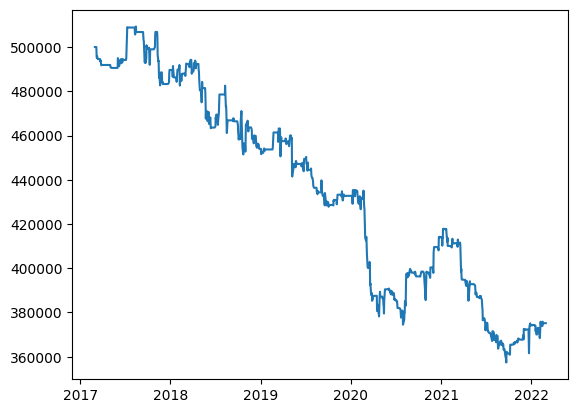

In [26]:
import matplotlib.pyplot as plt

chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result.portfolio.index, result.portfolio['market_value'])

Ayrıca tutulan her bir pozisyonun günlük bakiyesine, her giriş ve çıkış için yapılan işlemlere ve verilen tüm emirlere de erişebilirsiniz:

In [27]:
result.positions

long_shares  short_shares  close     equity  \
symbol   date                                                      
DOAS.IS  2017-03-07            0           100   9.40       0.00   
PGSUS.IS 2017-03-08         8322             0  14.50  120669.00   
DOAS.IS  2017-03-08            0           100   9.28       0.00   
EREGL.IS 2017-03-08        20903             0   5.85  122282.55   
PGSUS.IS 2017-03-09         8322             0  14.30  119004.60   
...                          ...           ...    ...        ...   
EREGL.IS 2022-02-14         3219             0  27.94   89938.86   
         2022-02-15         3219             0  28.56   91934.64   
DOAS.IS  2022-02-16            0           100  48.54       0.00   
EREGL.IS 2022-02-16         3219             0  28.18   90711.42   
DOAS.IS  2022-02-17            0           100  48.64       0.00   

                     market_value  margin  unrealized_pnl  
symbol   date                                              
DOAS.IS  2017-03-07        938.00   940.0           -2.00  
PGSUS.IS 2017-03-08     120669.00     0.0        -2579.82  
DOAS.IS  2017-03-08        938.00   928.0           10.00  
EREGL.IS 2017-03-08     122282.55     0.0        -1672.24  
PGSUS.IS 2017-03-09     119004.60     0.0        -4244.22  
...                           ...     ...             ...  
EREGL.IS 2022-02-14      89938.86     0.0         -579.42  
         2022-02-15      91934.64     0.0         1416.36  
DOAS.IS  2022-02-16       4865.00  4854.0           11.00  
EREGL.IS 2022-02-16      90711.42     0.0          193.14  
DOAS.IS  2022-02-17       4865.00  4864.0            1.00  

[850 rows x 7 columns]

In [28]:
result.trades

,type,symbol,entry_date,exit_date,entry,exit,shares,pnl,return_pct,agg_pnl,bars,pnl_per_bar,stop
id,,,,,,,,,,,,,
1,short,DOAS.IS,2017-03-07,2017-03-09,9.38,9.20,100,18.00,1.96,18.00,2,9.00,bar
2,long,EREGL.IS,2017-03-08,2017-03-13,5.93,5.88,20903,-1045.15,-0.84,-1027.15,3,-348.38,bar
3,long,PGSUS.IS,2017-03-08,2017-03-13,14.81,14.28,8322,-4410.66,-3.58,-5437.81,3,-1470.22,bar
4,long,EREGL.IS,2017-03-23,2017-03-28,6.00,5.87,20436,-2656.68,-2.17,-8094.49,3,-885.56,bar
5,short,DOAS.IS,2017-03-31,2017-04-04,8.55,8.48,100,7.00,0.83,-8087.49,2,3.50,bar
...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,long,PGSUS.IS,2022-02-02,2022-02-07,104.90,101.97,881,-2581.33,-2.79,-129278.74,3,-860.44,bar
337,long,EREGL.IS,2022-02-03,2022-02-08,27.24,28.30,3403,3607.18,3.89,-125671.56,3,1202.39,bar
338,short,DOAS.IS,2022-02-09,2022-02-11,48.78,47.69,100,109.00,2.29,-125562.56,2,54.50,bar


In [29]:
result.orders

,type,symbol,date,shares,limit_price,fill_price,fees
id,,,,,,,
1,sell,DOAS.IS,2017-03-07,100,NaN,9.38,0.0
2,buy,EREGL.IS,2017-03-08,20903,5.97,5.93,0.0
3,buy,PGSUS.IS,2017-03-08,8322,15.01,14.81,0.0
4,buy,DOAS.IS,2017-03-09,100,NaN,9.20,0.0
5,sell,EREGL.IS,2017-03-13,20903,NaN,5.88,0.0
...,...,...,...,...,...,...,...
676,buy,DOAS.IS,2022-02-11,100,NaN,47.69,0.0
677,buy,EREGL.IS,2022-02-14,3219,29.07,28.12,0.0
678,sell,DOAS.IS,2022-02-16,100,NaN,48.65,0.0


Ek olarak, ```result.metrics_df```, arka testin getirileri kullanılarak hesaplanan bir DataFrame metriği içerir. [Bu metriklerin ne anlama geldiğini referans belgelerden okuyabilirsiniz](https://www.pybroker.com/en/latest/reference/pybroker.eval.html#pybroker.eval.EvalMetrics).

In [30]:
result.metrics_df

,name,value
0,trade_count,3.400000e+02
1,initial_market_value,5.000000e+05
2,end_market_value,3.751790e+05
3,total_pnl,-1.248210e+05
4,unrealized_pnl,-1.455192e-11
5,total_return_pct,-2.496420e+01
6,total_profit,2.669176e+05
7,total_loss,-3.917386e+05
8,total_fees,0.000000e+00
9,max_drawdown,-1.519012e+05


## Arka Test Verilerini Filtreleme

Geri test için kullanılan verileri yalnızca belirli çubukları içerecek şekilde filtreleyebilirsiniz. Örneğin, verileri yalnızca Pazartesi günlerine ait çubukları içerecek şekilde filtreleyerek stratejiyi yalnızca Pazartesi günleri işlem yapacak şekilde sınırlayabilirsiniz:

In [31]:
result = strategy.backtest(days='mon')
result.orders

Backtesting: 2017-03-01 00:00:00 to 2022-03-01 00:00:00

Loaded cached bar data.

Test split: 2017-03-06 00:00:00 to 2022-02-28 00:00:00


  0% (0 of 258) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 66% (171 of 258) |##############        | Elapsed Time: 0:00:00 ETA:  00:00:00
100% (258 of 258) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Finished backtest: 0:00:00


,type,symbol,date,shares,limit_price,fill_price,fees
id,,,,,,,
1,buy,EREGL.IS,2017-04-17,22007,5.67,5.53,0.0
2,sell,DOAS.IS,2017-04-24,100,NaN,8.76,0.0
3,sell,EREGL.IS,2017-05-08,22007,NaN,6.31,0.0
4,buy,DOAS.IS,2017-05-08,100,NaN,9.11,0.0
5,sell,DOAS.IS,2017-05-22,100,NaN,8.70,0.0
...,...,...,...,...,...,...,...
200,sell,PGSUS.IS,2022-01-17,1659,NaN,106.70,0.0
201,sell,DOAS.IS,2022-01-24,100,NaN,49.13,0.0
202,buy,DOAS.IS,2022-02-07,100,NaN,46.70,0.0


Önbelleğe alma etkinleştirildiğinden ve önbelleğe alınan verilerin yalnızca filtrelenmesi gerektiğinden, verilerin Yahoo Finance'den tekrar indirilmesine gerek yoktur.

Ayrıca [aradaki_zamanı](https://www.pybroker.com/en/latest/reference/pybroker.strategy.html#pybroker) kullanarak verileri 09:30-10:30 gibi zaman aralığına göre de filtreleyebilirsiniz. .strategy.Strategy.backtest) argümanı.

Her ne kadar metrikler daha önce karlı bir stratejimiz olduğunu gösterse de, rastlantısallık nedeniyle yanılgıya düşebiliriz. [Bir sonraki not defterinde, ticaret stratejilerimizi daha ayrıntılı değerlendirmek için önyüklemeyi nasıl kullanacağımızı tartışacağız](https://www.pybroker.com/en/latest/notebooks/3.%20Evaluating%20with%20Bootstrap%20Metrics.html ).